In [1]:
## General modules
import numpy as np
import pandas as pd
import random 
import time
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import sklearn
import pickle
import subprocess
from tensorflow.keras import backend as K

## Dataset preparation
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ( 
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve,
    average_precision_score,
)


## (1) CRISPR-Net (OT_review)
from Programs.Evaluation import Encoder_sgRNA_off
from Programs.Evaluation.evaluate_CRISPR_Net import conv2d_bn, CRISPR_Net_model, CRISPR_Net_training,CRISPR_Net_testing

## (2) CRISPR-IP (OT_review)
from Programs.Programs.CRISPR_IP.codes.encoding import my_encode_on_off_dim
from Programs.Programs.CRISPR_IP.codes.CRISPR_IP import transformIO,crispr_ip

## (3) R-CRISPR (OT_review) (From CRISPR-M)
from Programs.Programs.R_CRISPR.encoding import encode_by_r_crispr_method
from Programs.Programs.R_CRISPR.R_CRISPR import ConvBn, RepVGGBlock, R_CRISPR_model, R_CRISPR_training

## (4) CRISPR-M (OT_review)
from Programs.Programs.CRISPR_M.positional_encoding import PositionalEncoding
from Programs.Programs.CRISPR_M.transformer_utils import add_encoder_layer, add_decoder_layer
from Programs.Programs.CRISPR_M.test_model import m81212_n13
from Programs.Programs.CRISPR_M.encoding import encode_by_base_pair_vocabulary, encode_by_base_vocabulary
from Programs.Programs.CRISPR_M.mismatch_test import Trainer

## (5) CrisprDNT (OT_review)
from Programs.Programs.CrisprDNT.model_network import transformIO,PositionalEncoding,new_crispr_ip,validate_tensor
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from keras_multi_head import MultiHeadAttention
from tensorflow.keras.layers import GRU,Embedding,Activation,ReLU,AveragePooling2D,MaxPool2D,BatchNormalization,Conv1D,Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling,RandomUniform
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from keras_layer_normalization import LayerNormalization
from tensorflow.keras.initializers import glorot_normal
import shutil
from keras_bert import get_custom_objects
from tensorflow.python.keras.layers.core import Reshape, Permute
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import multiply
from tensorflow.python.keras.layers.core import Dense, Dropout, Lambda, Flatten

## (6) CRISPR-SGRU (OT_review)
from Programs.Programs.Crispr_SGRU.MODEL import Crispr_SGRU

## Evaluation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

2025-04-07 20:00:10.517981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 20:00:10.538409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744074010.550879 1041316 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744074010.554333 1041316 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 20:00:10.574796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Import testing datasets

testing_files = [
    './Datasets/real_testing/Testing0.csv', # set 1
    './Datasets/real_testing/Testing1.csv', # set 2 
    './Datasets/real_testing/Testing3.csv', # set 4
    #'./Datasets/real_testing/Testing4.csv'  # set 5
]

testing_sets = []
label_test = []

for i in range(len(testing_files)):
    
    testing_file = pd.read_csv(testing_files[i], sep=',') 
    
    X = testing_file['sgRNA'].to_numpy()
    y = testing_file['DNA'].to_numpy()
    labels = testing_file['label']

    #testing_sets.append([X, y])
    testing_sets.append([X, y])
    #label_test.append(np.array(labels))
    label_test.append(np.array(labels))
    print(len(np.array(labels)))

110
294
234


testing_set0.csv
加区域分开编码
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]
[[0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 

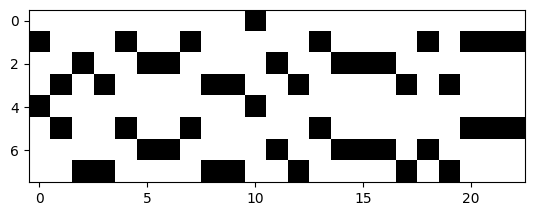

In [3]:
#2.2 Encoding for each program

###2.2.1 CRISPR-Net

####2.2.1.1 For testing data
encoded_seq_crispr_net_list = []
for i in range(len(testing_sets)):
    encoded_seqs = []
    for j in range(len(testing_sets[i][0])):
        on_target = testing_sets[i][0][j]
        off_target = testing_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_net_list.append(encoded_seqs)

encoded_seq_crispr_net_test = encoded_seq_crispr_net_list[:]

###2.2.2 CRISPR-IP

#### Encoding
encoded_testing_sets_crispr_ip_real = []

for i in range(len(testing_sets)):
    temp_list = []
    for j in range(len(testing_sets[i][0])):
        ont  = testing_sets[i][0][j]
        offt = testing_sets[i][1][j]
        test_data_encodings = np.array(my_encode_on_off_dim(ont,offt))
        temp_list.append(test_data_encodings)
    encoded_testing_sets_crispr_ip_real.append(temp_list)

###2.2.3 R-CRISPR

encoded_testing_sets_r_crispr = []

for i in range(len(testing_sets)):

    temp_set = []
    for j in range(len(testing_sets[i][0])):
        temp_set.append(encode_by_r_crispr_method(testing_sets[i][0][j],testing_sets[i][1][j]))
    encoded_testing_sets_r_crispr.append(temp_set)
    
    
###2.2.4 CRISPR-M

encoded_testing_sets_crispr_m = []
encoded_testing_sets_crispr_m_on = []
encoded_testing_sets_crispr_m_off = []

for i in range(len(testing_sets)):

    temp_set = []
    temp_set_on = []
    temp_set_off = []
    for j in range(len(testing_sets[i][0])):
        temp_set.append(encode_by_base_pair_vocabulary(testing_sets[i][0][j],testing_sets[i][1][j]))
        temp_set_on.append(encode_by_base_vocabulary(testing_sets[i][0][j]))
        temp_set_off.append(encode_by_base_vocabulary(testing_sets[i][1][j]))
     
    encoded_testing_sets_crispr_m.append(temp_set)
    encoded_testing_sets_crispr_m_on.append(temp_set_on)
    encoded_testing_sets_crispr_m_off.append(temp_set_off)
    
###2.2.5 CrisprDNT

for i in range(len(testing_sets)):

    sgrna_ = testing_sets[i][0]
    otdna_ = testing_sets[i][1]
    label_ = label_test[i]
    data = {'sgrna': sgrna_, 'otdna': otdna_, 'label': label_}
    df = pd.DataFrame(data)
    filename = 'testing_set' + str(i) +'.csv'
    df.to_csv(filename, index=False)
    
    %run '/home/remote_guest/Desktop/Programs/Programs/CrisprDNT/create_coding_scheme.py' {filename} {i} test


###2.2.6 Crispr-SGRU

####2.2.6.2 For testing data
encoded_seq_crispr_sgru_list = []
for i in range(len(testing_sets)):
    encoded_seqs = []
    for j in range(len(testing_sets[i][0])):
        on_target = testing_sets[i][0][j]
        off_target = testing_sets[i][1][j]
        e = Encoder_sgRNA_off.Encoder(on_seq=on_target, off_seq=off_target)
        encoded_seqs.append(e.on_off_code)
    encoded_seq_crispr_sgru_list.append(encoded_seqs)

encoded_seq_crispr_sgru_test = encoded_seq_crispr_sgru_list[:]

In [5]:
sets = ['HEK293T','K562','II3','II4','II5','II6']
set_num = ['ori_filtered200','ori_filtered200','ori_filtered200']

In [6]:
#2.4 Model testing
PATH = './Trained_models/public_datasets/CRISPR_Net'

###2.4.1 CRIPSR_Net

N = 0
for i in set_num:
    
    MODELs = [
        PATH + '/CRISPR_Net_model_HEK293T_' + str(i) + '.json',
        PATH + '/CRISPR_Net_model_K562_' + str(i) + '.json',
        PATH + '/CRISPR_Net_model_II3_' + str(i) + '.json',
        PATH + '/CRISPR_Net_model_II4_' + str(i) + '.json',
        PATH + '/CRISPR_Net_model_II5_' + str(i) + '.json',
        PATH + '/CRISPR_Net_model_II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + '/CRISPR_Net_model_HEK293T_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_Net_model_K562_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_Net_model_II3_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_Net_model_II4_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_Net_model_II5_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_Net_model_II6_' + str(i) + '.weights.h5',
    ]


    for j in range(len(MODELs)):
        MODEL   = MODELs[j]
        WEIGHT  = WEIGHTs[j]

        DATA_X = np.array(encoded_seq_crispr_net_test[N])
        DATA_X = DATA_X.reshape((len(DATA_X), 1, 24, 7))
        DATA_y = label_test[N]

        all_predictions = []
        for k in range(3):

            y_pred = CRISPR_Net_testing(WEIGHT, MODEL, DATA_X, DATA_y)

            all_predictions.append(y_pred)
        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)

        np.save('./New_evaluation_final/Testing/crispr_net_' + sets[j] + '_' + str(i) + str(N) +'.npy', average_predictions)
        
    N += 1
K.clear_session()

30 110


I0000 00:00:1744074067.206924 1041316 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19904 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Loaded model from disk!


I0000 00:00:1744074068.000403 2124588 cuda_dnn.cc:529] Loaded cuDNN version 90500


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
[5.5200297e-02 1.8376097e-02 5.3768337e-02 4.4790644e-02 2.2613470e-02
 2.5439695e-02 2.9473679e-02 3.1548019e-02 4.7469482e-02 2.6385151e-02
 2.1768626e-02 3.0502461e-02 4.2691652e-02 4.9752008e-02 5.2517060e-02
 3.8350679e-02 1.9880412e-02 2.6196301e-02 2.0494157e-02 9.2941485e-03
 6.9958144e-03 6.2817876e-04 1.8180123e-03 6.5843081e-03 4.7512432e-03
 4.3684421e-03 7.1265991e-03 5.5566290e-03 4.8902459e-03 1.0719011e-02
 4.1633353e-04 1.4704347e-03 2.0039086e-04 1.7345018e-03 8.3565107e-04
 1.0866931e-03 1.4200060e-03 1.3127354e-04 7.6322467e-04 3.3713126e-04
 4.4671292e-04 7.5821800e-04 4.1779681e-04 3.1486724e-04 3.5817991e-04
 2.0040690e-04 4.8268042e-04 2.3911189e-04 1.0560918e-04 2.1314366e-04
 3.6849864e-04 2.6076782e-04 3.2398180e-04 3.4098327e-04 1.6404776e-04
 2.3694366e-04 3.3921492e-04 6.7346147e-05 6.6109165e-04 7.7824188e-05
 2.0272488e-04 2.0998859e-04 2.0960970e-04 1.6239320e-04 3.5635557e-02
 4.7051825e-02 3.0989168e-02 1.6202584e

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.00822235 0.00597486 0.01079939 0.01039386 0.00728233 0.01060842
 0.0093265  0.00984185 0.01206288 0.00870444 0.00750848 0.01224952
 0.00761728 0.01088446 0.01089887 0.007261   0.01072204 0.0063368
 0.00826623 0.00832143 0.00330954 0.00359465 0.00335278 0.00370668
 0.0037741  0.00330879 0.0032328  0.00315194 0.00291326 0.0054968
 0.00414084 0.00301065 0.0037267  0.00378334 0.00448764 0.00440524
 0.00317785 0.0043978  0.00256808 0.00353745 0.00263032 0.00262214
 0.00253258 0.00215632 0.00231218 0.00331666 0.00230099 0.00206382
 0.0025331  0.0032644  0.00237032 0.00199379 0.00175185 0.00241393
 0.00242705 0.00209587 0.00227167 0.00258395 0.00244689 0.00256286
 0.00261449 0.00330581 0.00195584 0.00253212 0.00747558 0.00434843
 0.00842065 0.00989393 0.00734493 0.01008638 0.00945128 0.00747662
 0.00853969 0.00708158 0.00834416 0.0071106  0.00450045 0.00857071
 0.00496793 0.00974818 0.00760082 0.00680314 0.00621985 0.00256715
 0.00291326 0.00267472 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[5.4604012e-01 9.8746791e-03 5.3874099e-01 5.6649268e-01 4.5973781e-01
 5.1644003e-01 4.4263464e-01 5.2598709e-01 5.1336950e-01 5.3960121e-01
 4.6237749e-01 5.3835881e-01 4.3734848e-01 4.3289322e-01 5.1116741e-01
 4.2067796e-01 4.6334770e-01 5.4774278e-01 5.5821276e-01 5.1104361e-01
 1.2879944e-01 3.7975263e-09 7.7076777e-08 3.0140293e-06 2.4074869e-02
 5.1240495e-05 1.9059132e-04 1.9380460e-02 1.8238235e-03 3.3586093e-03
 3.9709979e-05 3.4121044e-07 1.5003665e-06 8.0508078e-05 2.1642455e-04
 2.0566706e-02 2.2991183e-06 3.4478875e-05 9.2569347e-10 1.7554107e-10
 1.2410121e-07 2.6309599e-10 4.9270530e-09 1.1970865e-09 3.3143150e-09
 5.4472994e-06 3.8527750e-10 1.0089030e-11 6.1827234e-07 9.5712885e-06
 2.1630673e-07 1.7233257e-08 9.8610384e-11 1.7410932e-09 6.3457005e-06
 1.6971022e-09 7.7679363e-07 3.2909056e-10 2.2638618e-11 3.3182198e-07
 4.4419618e-08 6.3300940e-06 6.7289609e-13 1.6311568e-13 3.1286798e-02
 1.7095201e-03 6.1074961e-02 2.8242992e

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[4.0516829e-06 2.3717582e-06 4.3219979e-06 5.4175516e-06 3.4523982e-06
 6.4070200e-06 3.1025802e-06 5.4488473e-06 5.6924209e-06 3.1766951e-06
 3.6959884e-06 7.8562507e-06 5.0175049e-06 5.8200139e-06 7.9013771e-06
 1.7145068e-06 6.9024850e-06 4.0579512e-06 4.7022145e-06 1.9931149e-05
 2.8587604e-06 2.0093510e-06 2.0267082e-06 3.7781801e-06 3.1373206e-06
 2.3029431e-06 2.3785672e-06 2.5770685e-06 2.6817006e-06 1.6586712e-06
 1.7455735e-06 1.3659927e-06 1.7227510e-06 1.4497341e-06 2.1582428e-06
 1.9982731e-06 1.3248055e-06 1.9955860e-06 6.5330846e-07 1.0259160e-06
 1.5146122e-06 6.7815267e-07 6.4320079e-07 6.9918320e-07 6.8248926e-07
 1.0317834e-06 5.2750863e-07 3.4599751e-07 5.3876812e-07 1.3199201e-06
 7.9712731e-07 4.2025107e-07 5.6623213e-07 4.4558831e-07 5.6519252e-07
 3.4711726e-07 3.4110045e-07 5.1748827e-07 2.8508629e-07 8.6066962e-07
 5.8539979e-07 6.5221843e-07 6.7941886e-07 4.2570025e-07 1.9427921e-06
 1.6313387e-06 2.4938818e-06 4.5215502e

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[2.85238214e-03 5.52192004e-03 2.50917347e-03 4.50267596e-03
 1.29073078e-03 4.75147553e-03 1.54964102e-03 4.38684318e-03
 4.35525505e-03 2.29090080e-03 8.89227667e-04 2.60204263e-03
 4.56163147e-03 6.26655202e-03 1.11071707e-03 6.84357190e-04
 4.23556520e-03 1.34707801e-03 3.28212953e-03 4.32402082e-03
 4.33621788e-03 2.61026551e-03 4.34909947e-03 8.33208149e-04
 2.44064187e-03 1.75994518e-03 1.78609171e-03 4.69718041e-04
 1.72567437e-03 5.87382214e-03 6.08854927e-03 1.67658075e-03
 3.33947525e-03 1.32366701e-03 2.87370826e-03 2.80703243e-04
 2.27320194e-03 4.37662617e-04 1.62504279e-04 2.68699223e-04
 8.77089566e-04 3.14925588e-03 1.18068408e-03 2.52740865e-05
 2.45808507e-04 4.79025679e-04 2.00309791e-03 3.07222083e-03
 3.53733019e-04 1.76596208e-04 1.06295585e-04 4.67344187e-03
 5.69324475e-04 4.94728665e-05 3.44024785e-03 5.82860841e-04
 1.08466588e-03 3.21351341e-03 7.60092051e-04 2.68013275e-04
 9.48544010e-04 3.73477174e-04 6.57814089e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0.00504253 0.00539051 0.00355564 0.00377288 0.00432156 0.00440495
 0.00392209 0.00433103 0.0031708  0.00439205 0.00285954 0.00371162
 0.0043511  0.00407007 0.00235104 0.00362591 0.00457986 0.00285823
 0.00292973 0.00296665 0.00403423 0.00334371 0.00467016 0.00241979
 0.00295511 0.00308351 0.00276465 0.00201452 0.00405931 0.0028073
 0.00413221 0.00237897 0.00307303 0.00192843 0.00244058 0.00246299
 0.0014754  0.00127544 0.00072919 0.00083545 0.00113988 0.00092735
 0.00129911 0.00112704 0.00149334 0.00079383 0.0018441  0.00219665
 0.00149482 0.00109028 0.00054509 0.00125431 0.00094586 0.00086432
 0.00176237 0.00159542 0.00123423 0.0011496  0.00151    0.00090189
 0.00134985 0.00074972 0.001189   0.0014757  0.00101919 0.00112222
 0.00113974 0.00096525 0.00076103 0.00088778 0.00170888 0.00078534
 0.00095807 0.00104386 0.00106569 0.0019618  0.00119241 0.00110875
 0.00166598 0.00114197 0.00157081 0.00099737 0.0008267  0.00283528
 0.00297704 0.00185755 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[7.48925865e-01 6.00904167e-01 6.72867239e-01 6.34931862e-01
 5.75530052e-01 5.02174437e-01 4.10931915e-01 7.22959042e-01
 5.95050275e-01 2.33594850e-01 4.68351960e-01 5.45945048e-01
 5.87855637e-01 3.57098162e-01 4.83306870e-03 9.53984261e-02
 2.10545808e-01 6.22251570e-01 3.23739648e-01 4.82400447e-01
 6.21630251e-01 4.54498887e-01 1.06397609e-03 1.23313731e-02
 7.82294333e-01 9.20741022e-01 3.74793887e-01 9.99999404e-01
 2.95132637e-01 7.14869499e-01 6.24485612e-01 4.13039885e-02
 1.01346351e-01 3.38361502e-01 8.65420029e-02 5.90955373e-04
 5.69458127e-01 9.11377847e-01 9.99999762e-01 9.99546111e-01
 9.99766171e-01 9.99786437e-01 1.47386710e-03 9.99998331e-01
 9.83766317e-01 9.99978065e-01 6.47315562e-01 6.84142292e-01
 7.80858576e-01 9.99987721e-01 1.00000000e+00 9.81806874e-01
 9.99981880e-01 9.99993205e-01 4.50219512e-02 6.30919814e-01
 9.79531288e-01 9.46529925e-01 7.56012499e-01 9.99536991e-01
 9.97730196e-01 9.99998093e-01 9.99977946e-01

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[7.48925865e-01 6.00904167e-01 6.72867239e-01 6.34931862e-01
 5.75530052e-01 5.02174437e-01 4.10931915e-01 7.22959042e-01
 5.95050275e-01 2.33594850e-01 4.68351960e-01 5.45945048e-01
 5.87855637e-01 3.57098162e-01 4.83306870e-03 9.53984261e-02
 2.10545808e-01 6.22251570e-01 3.23739648e-01 4.82400447e-01
 6.21630251e-01 4.54498887e-01 1.06397609e-03 1.23313731e-02
 7.82294333e-01 9.20741022e-01 3.74793887e-01 9.99999404e-01
 2.95132637e-01 7.14869499e-01 6.24485612e-01 4.13039885e-02
 1.01346351e-01 3.38361502e-01 8.65420029e-02 5.90955373e-04
 5.69458127e-01 9.11377847e-01 9.99999762e-01 9.99546111e-01
 9.99766171e-01 9.99786437e-01 1.47386710e-03 9.99998331e-01
 9.83766317e-01 9.99978065e-01 6.47315562e-01 6.84142292e-01
 7.80858576e-01 9.99987721e-01 1.00000000e+00 9.81806874e-01
 9.99981880e-01 9.99993205e-01 4.50219512e-02 6.30919814e-01
 9.79531288e-01 9.46529925e-01 7.56012499e-01 9.99536991e-01
 9.97730196e-01 9.99998093e-01 9.99977946e-01

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[9.09591094e-02 2.67416872e-02 1.58913565e-04 1.93738379e-02
 1.02755737e-04 3.80125898e-03 1.65464764e-03 3.31140868e-02
 4.28688363e-05 2.42255186e-03 2.02008072e-04 1.92681364e-05
 1.78411738e-05 1.10892215e-05 1.37657281e-08 1.02149340e-06
 2.92636483e-04 1.30118551e-05 1.12652103e-07 1.30891431e-05
 1.84015976e-03 5.95503880e-05 2.99170466e-07 4.06994882e-09
 7.78701974e-07 3.01071418e-10 1.73497983e-06 4.27334947e-12
 8.92494500e-05 2.11151466e-02 2.82399505e-02 1.28241879e-07
 7.57335215e-07 1.61579228e-04 1.66705053e-04 7.77429926e-11
 2.00847280e-05 1.87540934e-06 1.78867202e-13 5.79066517e-10
 1.26637665e-12 9.49928136e-09 2.85984896e-07 1.04367478e-14
 4.40107915e-11 1.70631109e-12 1.42065668e-03 5.71378274e-03
 1.94719578e-05 2.56782345e-10 1.11052372e-15 2.63739377e-08
 5.54547998e-13 3.67568267e-11 5.92587021e-11 1.14832401e-08
 9.77746666e-08 1.65964356e-12 4.52904452e-08 4.98884579e-11
 1.97530881e-12 1.74725490e-12 2.31522353e-11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[3.87407854e-05 4.08237029e-05 3.56130222e-05 2.87797247e-05
 5.56355371e-05 3.27448652e-05 4.19984390e-05 3.90553832e-05
 3.02455937e-05 4.14211027e-05 3.13566052e-05 2.63883740e-05
 3.63790750e-05 2.47513544e-05 3.02691387e-05 4.49015242e-05
 2.98837967e-05 3.19199571e-05 2.27133405e-05 2.84959751e-05
 3.36980629e-05 2.24900414e-05 2.04435055e-05 2.48443175e-05
 2.08867077e-05 2.51130878e-05 2.78380612e-05 2.11278511e-05
 7.31116379e-05 3.30899165e-05 4.19407697e-05 4.68791004e-05
 3.07314913e-05 4.26097395e-05 2.76883111e-05 1.55684131e-04
 3.26530935e-05 1.93078304e-05 1.17351628e-05 2.42027127e-05
 1.53339734e-05 1.10793799e-05 1.95237262e-05 3.50419941e-05
 4.35166621e-05 1.34969714e-05 3.87690961e-05 3.76727876e-05
 4.09067470e-05 1.23826367e-05 1.17473455e-05 1.18769576e-05
 1.09707908e-05 2.88512565e-05 3.10095711e-05 2.01340918e-05
 1.85692697e-05 1.15294552e-05 2.12594459e-05 1.96770543e-05
 1.54676545e-05 1.33648127e-05 4.95188870e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[3.87407854e-05 4.08237029e-05 3.56130222e-05 2.87797247e-05
 5.56355371e-05 3.27448652e-05 4.19984390e-05 3.90553832e-05
 3.02455937e-05 4.14211027e-05 3.13566052e-05 2.63883740e-05
 3.63790750e-05 2.47513544e-05 3.02691387e-05 4.49015242e-05
 2.98837967e-05 3.19199571e-05 2.27133405e-05 2.84959751e-05
 3.36980629e-05 2.24900414e-05 2.04435055e-05 2.48443175e-05
 2.08867077e-05 2.51130878e-05 2.78380612e-05 2.11278511e-05
 7.31116379e-05 3.30899165e-05 4.19407697e-05 4.68791004e-05
 3.07314913e-05 4.26097395e-05 2.76883111e-05 1.55684131e-04
 3.26530935e-05 1.93078304e-05 1.17351628e-05 2.42027127e-05
 1.53339734e-05 1.10793799e-05 1.95237262e-05 3.50419941e-05
 4.35166621e-05 1.34969714e-05 3.87690961e-05 3.76727876e-05
 4.09067470e-05 1.23826367e-05 1.17473455e-05 1.18769576e-05
 1.09707908e-05 2.88512565e-05 3.10095711e-05 2.01340918e-05
 1.85692697e-05 1.15294552e-05 2.12594459e-05 1.96770543e-05
 1.54676545e-05 1.33648127e-05 4.95188870e-05

Loaded model from disk!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[2.6017378e-06 2.2757092e-06 1.7114779e-06 1.5235551e-06 1.5951637e-06
 1.5614381e-06 1.5167543e-06 1.6138775e-06 1.7167156e-06 1.8266325e-06
 1.2561586e-06 1.5409661e-06 9.4650807e-07 8.7057583e-07 1.6246300e-06
 1.2090272e-06 1.4820117e-06 1.1320884e-06 1.5606714e-06 1.2852033e-06
 1.0846254e-06 9.3188186e-07 5.8370392e-07 7.5919581e-07 6.0501594e-07
 6.0803541e-07 1.0970526e-06 2.2070137e-07 4.3404366e-06 2.8615484e-06
 3.7764949e-06 2.0080522e-06 2.5743345e-06 1.5165866e-06 1.5857808e-06
 1.3877343e-06 2.6207085e-06 1.0553171e-06 2.2563198e-07 8.0623136e-07
 3.7765057e-07 6.2182437e-07 1.3892743e-06 6.2530739e-07 8.4070660e-07
 4.5865727e-07 2.2227382e-06 2.6289870e-06 1.4407119e-06 2.8697283e-07
 2.6659012e-07 4.7277547e-07 5.6335483e-07 4.8999107e-07 2.4011442e-06
 7.9940963e-07 7.6107546e-07 6.0523007e-07 6.5583293e-07 6.8248926e-07
 4.7369701e-07 3.5493906e-07 7.7258977e-07 1.2570202e-06 4.6919516e-07
 8.6579843e-0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[6.82238198e-04 4.67566913e-03 2.28349515e-03 7.36344839e-03
 1.51902437e-03 1.63283641e-03 2.07266421e-03 1.88801938e-03
 1.46581058e-03 6.45975210e-03 1.79130572e-03 1.01994565e-02
 9.21582337e-04 7.25621404e-03 5.38699422e-03 5.76345855e-03
 1.95574434e-03 5.11069037e-03 5.73379314e-03 6.40132139e-03
 1.60567928e-03 6.62291772e-04 8.65255482e-03 2.41160835e-03
 7.46450713e-03 7.38211791e-04 2.83080910e-04 8.21334543e-04
 7.35450885e-04 6.59671263e-04 6.38286176e-04 1.22134015e-03
 3.12819684e-05 3.27918259e-03 2.48339929e-04 3.75796895e-04
 1.34532410e-03 5.84789494e-04 5.52983372e-04 1.72282150e-03
 6.27320784e-04 5.08865633e-04 2.22621206e-03 3.73897201e-04
 3.27648013e-04 2.02201176e-04 9.51551949e-04 1.15876715e-03
 1.10329094e-03 4.18636846e-05 1.84974528e-03 1.98673108e-04
 1.38789532e-03 1.26954517e-03 1.12798662e-04 3.90039029e-04
 6.98173826e-04 5.81988250e-04 3.44634784e-04 1.63960073e-03
 3.43463034e-04 4.43070807e-04 1.26023006e-04 7

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.0066242  0.00278001 0.00372029 0.002055   0.00276362 0.00174514
 0.00158833 0.00120381 0.00150909 0.00222524 0.00201454 0.00205524
 0.0014804  0.00639476 0.00499616 0.0079195  0.00594327 0.00642282
 0.00852683 0.01128309 0.00899952 0.00619765 0.00278393 0.00227994
 0.00156594 0.0026299  0.00360674 0.00292951 0.00549667 0.00234505
 0.00207442 0.0033636  0.00137819 0.00343326 0.0029466  0.00371742
 0.00488359 0.00197142 0.00378275 0.00428611 0.00313263 0.00356436
 0.00441598 0.00236884 0.00300585 0.00384003 0.00203874 0.0044948
 0.0032051  0.00127297 0.00248746 0.00375851 0.00397595 0.00331362
 0.0015965  0.00403879 0.00269169 0.00147225 0.00264935 0.00236179
 0.00218073 0.00263903 0.00107745 0.00360132 0.00278504 0.00497574
 0.00362191 0.00280201 0.00227475 0.00328756 0.00216275 0.00359786
 0.00277664 0.00272037 0.00184436 0.00142308 0.00358728 0.00202876
 0.00150242 0.00271973 0.00291595 0.00347525 0.00128211 0.0019296
 0.00413683 0.00197665 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[6.50009930e-01 6.56681180e-01 6.51473999e-01 1.10487223e-01
 2.72547841e-01 9.99998927e-01 9.98821676e-01 1.00000000e+00
 9.99999881e-01 5.05875409e-01 9.99700546e-01 9.99794424e-01
 1.00000000e+00 5.40946126e-01 6.48675919e-01 4.98324305e-01
 7.23854780e-01 2.50197742e-02 7.01491296e-01 7.06474066e-01
 6.70089781e-01 4.22493398e-01 1.14321589e-01 9.49267894e-02
 4.23580408e-02 1.94342247e-05 8.77323560e-04 6.45613577e-03
 6.61672175e-01 1.03649691e-01 8.32112610e-01 4.73986799e-03
 9.99999762e-01 2.06325296e-02 6.02666335e-03 1.32561568e-03
 6.75813317e-01 3.25859222e-03 4.41855425e-03 1.89788267e-03
 6.11377298e-04 5.17083220e-02 7.25902675e-04 9.98972893e-01
 8.91020638e-04 4.81840281e-04 2.38504072e-05 2.11130783e-01
 5.88966124e-02 9.99997854e-01 4.84387577e-02 5.11238643e-04
 6.72067925e-02 2.72003189e-03 1.00000000e+00 3.21882567e-03
 6.64782710e-04 5.90292394e-01 7.53307939e-01 6.44843886e-03
 6.21587217e-01 9.99783695e-01 1.00000000e+00 6

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[1.72245018e-02 9.86926481e-02 3.50978702e-01 2.20355135e-03
 2.66856682e-06 4.70905953e-11 2.52041313e-12 5.79627004e-13
 1.46056361e-11 1.48764820e-10 1.83199331e-10 1.83506821e-09
 8.45218264e-14 3.72094274e-01 1.37046024e-01 3.40097219e-01
 1.21236995e-01 9.30647738e-03 5.30874968e-01 1.84329778e-01
 4.27530706e-01 1.66391628e-03 5.69894291e-05 2.15961827e-05
 3.61824874e-04 1.68953653e-11 4.26749504e-11 2.68950180e-06
 5.14234975e-03 6.36886252e-05 3.13372061e-06 2.66543861e-06
 7.17294605e-14 2.53942970e-04 2.06309955e-10 4.24718934e-07
 3.57864611e-02 5.22083665e-09 6.02774275e-09 5.01674169e-09
 5.22468957e-10 2.37642169e-07 4.76359840e-10 2.64786218e-12
 5.36664602e-10 2.46361792e-10 1.29884905e-11 3.70840917e-06
 9.16859193e-08 8.76535042e-12 4.06953506e-04 1.35230174e-10
 6.58608542e-06 3.78546247e-07 3.71926534e-15 4.65365900e-07
 1.66205683e-09 3.24035558e-13 3.30371925e-08 1.08395143e-05
 5.48865944e-12 1.63267631e-12 4.74484513e-14 1

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[1.53762405e-04 5.62402820e-05 8.94194818e-05 3.83537044e-05
 4.38830175e-05 1.08382219e-05 2.34869003e-05 5.94938319e-06
 7.50971958e-06 1.05763193e-05 1.12632806e-05 9.82829442e-06
 6.75999308e-06 5.59589389e-05 4.25260369e-05 5.71363526e-05
 6.15802128e-05 4.51997585e-05 5.69105214e-05 6.39700811e-05
 1.56633672e-04 1.39816344e-04 3.31467345e-05 5.26602598e-05
 3.28052192e-05 3.34260694e-05 6.30818249e-05 6.14938253e-05
 6.14992823e-05 5.22351329e-05 2.38592602e-05 5.24426105e-05
 2.83543650e-05 4.04824677e-05 4.29650536e-05 8.21377180e-05
 6.05928981e-05 3.33249845e-05 9.86722589e-05 4.11221044e-05
 4.29637475e-05 5.97735270e-05 4.37127710e-05 3.24305511e-05
 5.46646042e-05 5.22930968e-05 2.65359267e-05 6.18816121e-05
 3.76358730e-05 2.35780790e-05 2.69178345e-05 7.42794582e-05
 4.43721656e-05 4.69893421e-05 1.63127352e-05 4.15720351e-05
 3.78730692e-05 2.01877338e-05 2.72860798e-05 3.81971877e-05
 3.17963641e-05 3.22725027e-05 1.29458085e-05 3

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[2.61517630e-06 4.57568194e-06 8.25008829e-06 3.47021705e-06
 3.19717060e-06 3.07142557e-07 8.23894084e-07 1.76262645e-07
 2.16804679e-07 8.53781387e-07 4.82212329e-07 6.14186206e-07
 2.48383657e-07 2.19164667e-06 1.50620872e-06 3.11710687e-06
 2.45082902e-06 1.54647500e-06 3.55018028e-06 7.61356750e-06
 4.62186745e-06 1.79826679e-06 2.64387882e-06 3.77361425e-06
 3.20443837e-06 1.08491292e-06 2.18854098e-06 1.59386343e-06
 3.21890457e-06 1.31012303e-06 7.18022136e-07 1.78742175e-06
 2.75478897e-07 2.67323321e-06 1.45317233e-06 2.19513163e-06
 4.40978829e-06 9.75268222e-07 3.28428905e-06 2.18363516e-06
 1.57093029e-06 1.77242975e-06 2.12575924e-06 4.77677304e-07
 1.63783750e-06 1.28154261e-06 1.24351232e-06 4.09873519e-06
 3.06109314e-06 2.58219018e-07 1.13146029e-06 2.86860040e-06
 2.88863521e-06 2.93564131e-06 1.47164712e-07 2.17453521e-06
 1.32879882e-06 8.13177962e-07 9.58748160e-07 1.17226978e-06
 7.41869428e-07 5.22478899e-07 1.76192387e-07 2

In [7]:
###2.4.2 CRISPR-IP
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda

def transpose_function(x):
    return tf.transpose(x, perm=[0, 2, 1])
        
def transpose_output_shape(input_shape):
    return (input_shape[0], input_shape[2], input_shape[1])

input_shape = (1, 24, 7)

PATH = './Trained_models/public_datasets/CRISPR_IP'

N = 0
for i in set_num:
    
    MODELs = [
        PATH + '/CRISPR_IP_model_HEK293T_' + str(i) + '.json',
        PATH + '/CRISPR_IP_model_K562_' + str(i) + '.json',
        PATH + '/CRISPR_IP_model_II3_' + str(i) + '.json',
        PATH + '/CRISPR_IP_model_II4_' + str(i) + '.json',
        PATH + '/CRISPR_IP_model_II5_' + str(i) + '.json',
        PATH + '/CRISPR_IP_model_II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + '/CRISPR_IP_model_HEK293T_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_IP_model_K562_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_IP_model_II3_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_IP_model_II4_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_IP_model_II5_' + str(i) + '.weights.h5',
        PATH + '/CRISPR_IP_model_II6_' + str(i) + '.weights.h5',
    ]
    
    for j in range(len(MODELs)):

        MODEL = MODELs[j]
        WEIGHT  = WEIGHTs[j]

        # Load the model architecture from JSON
        with open(MODEL, "r") as json_file:
            loaded_model_json = json_file.read()

        # Load the model
        model = model_from_json(loaded_model_json, custom_objects={
            'transpose_function': transpose_function,
            'transpose_output_shape': transpose_output_shape
        })

        model.load_weights(WEIGHT)

        xtest = np.array(encoded_testing_sets_crispr_ip_real[N]).reshape(np.array(encoded_testing_sets_crispr_ip_real[N]).shape[0], 1, 24, 7)
        xtest = xtest.astype('float32')
        ytest = label_test[N]

        all_predictions = []
        for k in range(3):

            yscore = model.predict(xtest)
            ypred = np.argmax(yscore, axis=1)
            yscore = yscore[:,1]

            all_predictions.append(yscore)
        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)
        
        np.save('./New_evaluation_final/Testing/crispr_ip_' + sets[j] + '_' + str(i) + str(N) + '.npy', average_predictions)
        
    N += 1
K.clear_session()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [8]:
###2.4.3 R-CRISPR

PATH = './Trained_models/public_datasets/R_CRISPR/R_CRISPR_model_'

N = 0
for i in set_num:
    
    MODELs = [
        PATH + 'HEK293T_' + str(i) + '.json',
        PATH + 'K562_' + str(i) + '.json',
        PATH + 'II3_' + str(i) + '.json',
        PATH + 'II4_' + str(i) + '.json',
        PATH + 'II5_' + str(i) + '.json',
        PATH + 'II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + 'HEK293T_' + str(i) + '.weights.h5',
        PATH + 'K562_' + str(i) + '.weights.h5',
        PATH + 'II3_' + str(i) + '.weights.h5',
        PATH + 'II4_' + str(i) + '.weights.h5',
        PATH + 'II5_' + str(i) + '.weights.h5',
        PATH + 'II6_' + str(i) + '.weights.h5',
    ]
    
    for j in range(len(MODELs)):

        MODEL = MODELs[j]
        WEIGHT  = WEIGHTs[j]


        # Load the model architecture from JSON
        with open(MODEL, "r") as json_file:
            loaded_model_json = json_file.read()

        # Load the model
        model = model_from_json(loaded_model_json)
        model.load_weights(WEIGHT)


        xtest = np.array(encoded_testing_sets_r_crispr[N], dtype=np.float32)
        #test = xtest.reshape(1, 24, 7)
        ytest = label_test[N]

        all_predictions = []
        for k in range(3):

            yscore = model.predict(xtest)
            all_predictions.append(yscore)

        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)
        np.save('./New_evaluation_final/Testing/r_crispr_' + sets[j] + '_' + str(i) + str(N) + '.npy', average_predictions)
        
    N += 1
K.clear_session()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [9]:
###2.4.4CRISPR-M

PATH = './Trained_models/public_datasets/CRISPR_M/CRISPR_M_model_'

N = 0
for i in set_num:
    
    MODELs = [
        PATH + 'HEK293T_' + str(i) + '.json',
        PATH + 'K562_' + str(i) + '.json',
        PATH + 'II3_' + str(i) + '.json',
        PATH + 'II4_' + str(i) + '.json',
        PATH + 'II5_' + str(i) + '.json',
        PATH + 'II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + 'HEK293T_' + str(i) + '.weights.h5',
        PATH + 'K562_' + str(i) + '.weights.h5',
        PATH + 'II3_' + str(i) + '.weights.h5',
        PATH + 'II4_' + str(i) + '.weights.h5',
        PATH + 'II5_' + str(i) + '.weights.h5',
        PATH + 'II6_' + str(i) + '.weights.h5',
    ]
    
    for j in range(len(MODELs)):

        MODEL = MODELs[j]
        WEIGHT  = WEIGHTs[j]

        # Load the model architecture from JSON
        with open(MODEL, "r") as json_file:
            loaded_model_json = json_file.read()

        # Load the model
        model = model_from_json(loaded_model_json)
        model.load_weights(WEIGHT)


        xtest = np.array(encoded_testing_sets_crispr_m[N], dtype=np.float32)
        xtest_on = np.array(encoded_testing_sets_crispr_m_on[N], dtype=np.float32)
        xtest_off = np.array(encoded_testing_sets_crispr_m_off[N], dtype=np.float32)
        #test = xtest.reshape(1, 24, 7)
        ytest = label_test[N]

        all_predictions = []
        for k in range(3):

            yscore = model.predict([xtest,xtest_on,xtest_off])
            all_predictions.append(yscore)

        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)
        np.save('./New_evaluation_final/Testing/crispr_m_' + sets[j] + '_' + str(i) + str(N) + '.npy', average_predictions)
        
    N += 1
K.clear_session()         

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [10]:
###2.4.5 CrisprDNT

from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention, Dense, Conv2D, Bidirectional, LSTM, Flatten, Input, Activation, Reshape, Dropout, Concatenate, AveragePooling1D, MaxPool1D, BatchNormalization, Attention, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, AdditiveAttention, AlphaDropout, LeakyReLU
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers.core import Dense, Dropout, Lambda, Flatten


class TransposeLayer(tf.keras.layers.Layer):
    def __init__(self, perm, **kwargs):
        super(TransposeLayer, self).__init__(**kwargs)  # Pass additional arguments to the parent class
        self.perm = perm

    def call(self, inputs):
        return tf.transpose(inputs, perm=self.perm)

    def get_config(self):
        # Ensure the configuration includes the necessary attributes
        config = super(TransposeLayer, self).get_config()
        config.update({"perm": self.perm})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)  # Accept any additional arguments from the saved JSON

    

encoder_shape = (23, 14)
seg_len, coding_dim = encoder_shape
num_classes = 2
epochs = 100
retrain=False
list_type = ['14x23']
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001,#0.0001
    patience=10, verbose=0, mode='auto')
callbacks = [early_stopping]


PATH = './Trained_models/public_datasets/CrisprDNT/CrisprDNT_model_'

N = 0
for i in set_num:
    
    MODELs = [
        PATH + 'HEK293T_' + str(i) + '.json',
        PATH + 'K562_' + str(i) + '.json',
        PATH + 'II3_' + str(i) + '.json',
        PATH + 'II4_' + str(i) + '.json',
        PATH + 'II5_' + str(i) + '.json',
        PATH + 'II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + 'HEK293T_' + str(i) + '.weights.h5',
        PATH + 'K562_' + str(i) + '.weights.h5',
        PATH + 'II3_' + str(i) + '.weights.h5',
        PATH + 'II4_' + str(i) + '.weights.h5',
        PATH + 'II5_' + str(i) + '.weights.h5',
        PATH + 'II6_' + str(i) + '.weights.h5',
    ]
    

    for j in range(len(MODELs)):

        MODEL = MODELs[j]
        WEIGHT  = WEIGHTs[j]

        # Load the model architecture from JSON
        with open(MODEL, "r") as json_file:
            loaded_model_json = json_file.read()

        # Load the model
        model = model_from_json(loaded_model_json, custom_objects={
            'TransposeLayer': TransposeLayer,
        })

        model.load_weights(WEIGHT)

        with open("encodedmismatchtype14x23cd33withoutTsai" + str(N) + "train.pkl", "rb") as f:
            data = pickle.load(f, encoding = 'latin1')

        with open("encodedmismatchtype14x23cd33withoutTsai" + str(N) + 'test.pkl', "rb") as f:
            data_ = pickle.load(f, encoding = 'latin1')

        X_train = data.images
        y_train = data.target 

        X_test = data_.images
        y_test = data_.target  


        xtrain, xtest, ytrain, ytest, inputshape = transformIO(
        X_train, X_test, y_train, y_test, seg_len, coding_dim, num_classes)


        all_predictions = []
        for k in range(3):

            yscore = model.predict(xtest)
            yscore = yscore[:, 1]
            all_predictions.append(yscore)

        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)
        np.save('./New_evaluation_final/Testing/crisprdnt_' + sets[j] + '_' + str(i) + str(N) + '.npy', average_predictions)
        
    N += 1
K.clear_session()    

I0000 00:00:1744074127.638918 2124594 service.cc:148] XLA service 0x5f6c06c92a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744074127.639040 2124594 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-07 20:02:07.669959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-07 20:02:08.301157: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

I0000 00:00:1744074128.980281 2124594 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-07 20:02:09.930122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
 1/10 ━━━━━━━━━━━━━━━━━━━━ 8s 899ms/step

2025-04-07 20:02:23.900547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/8 ━━━━━━━━━━━━━━━━━━━━ 6s 905ms/step

2025-04-07 20:02:38.491196: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [11]:
###2.4.6 Crispr-SGRU

PATH = './Trained_models/public_datasets/Crispr_SGRU/Crispr_SRGU_model_'

N = 0
for i in set_num:
    
    MODELs = [
        PATH + 'HEK293T_' + str(i) + '.json',
        PATH + 'K562_' + str(i) + '.json',
        PATH + 'II3_' + str(i) + '.json',
        PATH + 'II4_' + str(i) + '.json',
        PATH + 'II5_' + str(i) + '.json',
        PATH + 'II6_' + str(i) + '.json',
    ]

    WEIGHTs = [
        PATH + 'HEK293T_' + str(i) + '.weights.h5',
        PATH + 'K562_' + str(i) + '.weights.h5',
        PATH + 'II3_' + str(i) + '.weights.h5',
        PATH + 'II4_' + str(i) + '.weights.h5',
        PATH + 'II5_' + str(i) + '.weights.h5',
        PATH + 'II6_' + str(i) + '.weights.h5',
    ]
    

    for j in range(len(MODELs)):

        MODEL = MODELs[j]
        WEIGHT  = WEIGHTs[j]

#         # Load the model architecture from JSON
#         with open(MODEL, "r") as json_file:
#             loaded_model_json = json_file.read()

            
            
        import json

        # Read model JSON
        with open(MODEL, 'r') as f:
            model_json = json.load(f)

        # Fix the 'batch_shape' key in the InputLayer
        for layer in model_json['config']['layers']:
            if layer['class_name'] == 'InputLayer' and 'batch_shape' in layer['config']:
                layer['config']['batch_input_shape'] = layer['config'].pop('batch_shape')

        # Convert back to string
        patched_json = json.dumps(model_json)

        # Load the model
        from tensorflow.keras.models import model_from_json
        model = model_from_json(patched_json)
        

        # Load the model
#         model = model_from_json(loaded_model_json)
        model.load_weights(WEIGHT)


        X_test = np.array(encoded_seq_crispr_sgru_test[N])
        X_test = X_test.reshape((len(X_test), 1, 24, 7))
        y_test = label_test[N]

        print(len(X_test))


        all_predictions = []
        for k in range(3):

            ypred = model.predict(X_test)
            all_predictions.append(ypred)

        all_predictions = np.array(all_predictions)
        average_predictions = np.mean(all_predictions, axis=0)
        np.save('./New_evaluation_final/Testing/crispr_sgru_' + sets[j] + '_' + str(i) + str(N) + '.npy', average_predictions)
        
    N += 1
K.clear_session()    

110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
294
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
294
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
294
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
